## FBCCA and Extended FBCCA for SSVEP signals classification

In [2]:
# Imports:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io as sio

import re

from sklearn.cross_decomposition import CCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

from scipy.signal import butter, lfilter

import os

## Description of the task:

To implement the FBCCA method on python, follow these steps:

- Define the parameters for the FBCCA method, such as the number of harmonics (Nh), the weight vector (w), the number of sub-bands (N), and the filter bank design (M1, M2, or M3): (M1: sub-bands with equally spaced bandwidths; M2: sub-bands corresponding to individual harmonic frequency bands; M3: sub-bands covering multiple harmonic frequency bands.

- Define the reference signals for each stimulation frequency using function 5 (generate_ref_signgal). The reference signals should have a shape of (n_samples, Nh * 2), where n_samples is the number of samples in your signal window.

- Define a function to perform CCA between two multi-dimensional variables. Use the CCA module from sklearn.cross_decomposition.

- Define a function to perform filter bank analysis on your SSVEP signals using a zero-phase Chebyshev Type I IIR filter. You can use the filtfilt() function from scipy.signal to apply the filter. The filter bank analysis should output a set of sub-band signals, each with a shape of (n_samples, n_channels), where n_channels is the number of channels in your signals.

- For each sub-band signal, apply the CCA function to calculate the correlation vector between the sub-band signal and the reference signals for each stimulation frequency using equation (5). The correlation vector should have a shape of (1, Nh * 2).

- For each stimulation frequency, calculate the feature vector by using a weighted sum of squares of the correlation values corresponding to all sub-band components using equation (6). The feature vector should have a shape of (1, N).

- Compare the feature vector with a threshold value to determine the target frequency. The threshold value can be optimized by a grid search method. If the feature vector exceeds the threshold value, then the target frequency is the frequency corresponding to the reference signal. If not, then the target frequency is unknown.
Source: "Filter bank canonical correlation analysis for implementing a high-speed" by Xiaogang Chen, et al. 2015
SSVEP-based brain-computer interface
https://pubmed.ncbi.nlm.nih.gov/26035476/


> Obs:

The bandwidth of the stimulation frequencies (8-15.8Hz) was 8Hz in this study

Therefore, the frequency
range within [8Hz 88Hz] (i.e., 10 times of the bandwidth of the stimulation frequencies)

In [3]:
"""Utility functions"""

# Function 5: generate_ref_signal
# Input: Freq_phase_path, SSVEP frecuencies (targets), number of samples, number of harmonics, sampling frequency
# Output: reference signal
def generate_ref_signal(Freq_phase_path: str, freqs: list, N: int, n_harmonics: int, fs: int) -> np.ndarray:
    data = sio.loadmat(Freq_phase_path)
    index_freqs = data['freqs'].round(1).reshape(-1).tolist()
    phases = data['phases'].reshape(-1)  # phases

        # Reference signal
    ref_signal = np.zeros((N, len(freqs), n_harmonics * 2,))
    # For each frequency
    f = 0
    for frequency in freqs:
        phase = phases[index_freqs.index(round(frequency, 1))]
        
        # For each harmonic
        for i in range(0, n_harmonics):
            # Sinusoid
            ref_signal[:, f, i] = np.sin(2 * np.pi * frequency * (i + 1) * np.arange(N) / fs + phase)
            # Cosinusoid
            ref_signal[:, f, i + 1] = np.cos(2 * np.pi * frequency * (i + 1) * np.arange(N) / fs + phase)
       
        f+=1

    return ref_signal.swapaxes(0, 2)

# Function 1: filter_bank_analysis
# Input: signal, sampling frequency, number of sub-bands, filter bank design
# Output: sub-band signals
def filter_bank_analysis(in_signal, fs, n_subbands, filter_bank_design, low_freq, up_freq):
    # Number of channels
    n_channels = in_signal.shape[0]
    # Number of samples
    n_samples = in_signal.shape[1]

    gpass, gstop, Rp = 3, 40, 0.5
    highcut_pass, highcut_stop = 80, 90

    # Filter bank design
    if filter_bank_design == 'M1': # N_subbands of the same length
        # Sub-band signals
        subband_signals = np.zeros((n_subbands, n_channels, n_samples))
        # For each sub-band
        for i in range(0, n_subbands):
            
            passband = low_freq * (i + 2)
            stopband = low_freq * (i + 1)
            
            Wp = [passband / (fs/2), highcut_pass / (fs/2)]
            Ws = [stopband / (fs/2), highcut_stop / (fs/2)]
            
            N, Wn = signal.cheb1ord(Wp, Ws, gpass, gstop)
            
            # Sub-band filter
            b, a = signal.cheby1(N, 0.1, Wn, 'bandpass')
            # Filtered signal
            subband_signals[i, :, :] = signal.filtfilt(b, a, in_signal)
    
    elif filter_bank_design == 'M2':
        raise NotImplementedError()
    
    elif filter_bank_design == 'M3':
        raise NotImplementedError()
    
    else:
        raise NotImplementedError("Design not supported")

    return subband_signals

#  - Define a function to perform CCA between two multi-dimensional variables. Use the CCA module from sklearn.cross_decomposition.
# Function 2: cca
# Input: signal 1, signal 2
# Output: correlation vector
def cca(signal1, signal2):
    # Canonical correlation analysis
    cca = CCA(1)
    
    # Fit the model with signal 1 and signal 2
    cca.fit(signal1.T, signal2.T)

    # Correlation vector
    X_c, Y_c = cca.transform(signal1.T, signal2.T)

    return X_c, Y_c

# Function 3: feature_extraction
# Input: sub-band signals, reference signals, weight vector
# Output: feature vector
def feature_extraction(subband_signals, ref_signals, n_freq):
    # Number of sub-band signals
    n_subbands = subband_signals.shape[0]
    # Feature vector
    feature_vector = np.zeros(ref_signals.shape[1])
    # Class predicted
    fb_coefs = [pow(i, -1.25) + 0.25 for i in range(1, n_subbands + 1)]
    result = 0
    # For each sub-band signal
    for sub in range(n_subbands):
        for freq in range(ref_signals.shape[1]):
            # Correlation vector
            X_c, Y_c = cca(subband_signals[sub, :, :], ref_signals[:, freq, :])
            # Pearson correlation coefficient
            correl = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1]
        
            feature_vector[freq] = np.max(correl)
            result += (fb_coefs[sub] * (feature_vector ** 2))

        predicted = np.argmax(result) + 1

    return predicted


# Function 4: fbcca
# Input: signal, sampling frequency, number of harmonics, number of sub-bands, filter bank design, weight vector, reference signals
# Output: target frequency
def fbcca(in_signal, fs, n_subbands, filter_bank_design, w, ref_signals, lowest_freq, upmost_freq):
    # Sub-band signals
    in_signal = in_signal.swapaxes(0, 1)
    subband_signals = filter_bank_analysis(in_signal, fs, n_subbands, filter_bank_design, lowest_freq, upmost_freq)
    # Target frequency
    predicted = feature_extraction(subband_signals, ref_signals, w)
    return predicted



The frequency and phase values are used to generate the SSVEP stimuli. The stimuli are generated by the following equation:

$$
x(t) = sin(2\pi f t + \phi)
$$

where $f$ is the frequency and $\phi$ is the phase value.

In [4]:
# SSVEP target frequencies
frequencies = [8, 10]
# Number of samples
N = 1000
# Sampling frequency
fs = 250
# Number of harmonics
n_harmonics = 3
# Number of sub-bands
n_subbands = 8
# Filter bank design
filter_bank_design = 'M1'
# Weight vector
w = np.ones((2, n_harmonics * 2))
# Reference signals
ref_signals = generate_ref_signal('data/raw/Freq_Phase.mat', frequencies, N, n_harmonics, fs)

In [21]:
def get_acc_of_subject(subject, path, w_size = 4):
    
    # get all .npy files of the subject
    files = os.listdir(path)

    label = int(path.split("/")[-2]) + 1

    predictions = []

    for file in files:

        if re.match(f"^{subject}_.\.npy$", file) and file.endswith(".npy"):
            
            in_signal = np.load(path + file)[:int(w_size * 250), :]
            target_frequency = fbcca(in_signal, fs, n_subbands, filter_bank_design, w, ref_signals[:, :, :int(w_size * 250)], 8, 88)
            predictions.append(target_frequency)
        
    targets = np.ones(len(predictions)) * label
    # calculate the accuracy
    acc = accuracy_score(targets, predictions)

    return acc


In [22]:
window_sizes = [1, 1.5, 2, 2.5, 3, 3.5, 4]

path = "data/staged/1/"

for window_size in window_sizes:
    accs = []

    for i in range(1, 36):
        acc = get_acc_of_subject(f"S{i}", path, window_size)
        accs.append(acc)

    print(f"Accuracy for window size {window_size}: {np.mean(accs)}")

# accs = []

# for i in range(1, 36):
#     acc = get_acc_of_subject(f"S{i}", path, window_size)
#     accs.append(acc)

# print(f"Accuracy for window size {window_size}: {np.mean(accs)}")

Accuracy for window size 1: 0.7102040816326531
Accuracy for window size 1.5: 0.7591836734693878
Accuracy for window size 2: 0.8244897959183675
Accuracy for window size 2.5: 0.8122448979591838
Accuracy for window size 3: 0.8448979591836734
Accuracy for window size 3.5: 0.8489795918367347
Accuracy for window size 4: 0.8897959183673471


an improvement of 0.012215743439553006


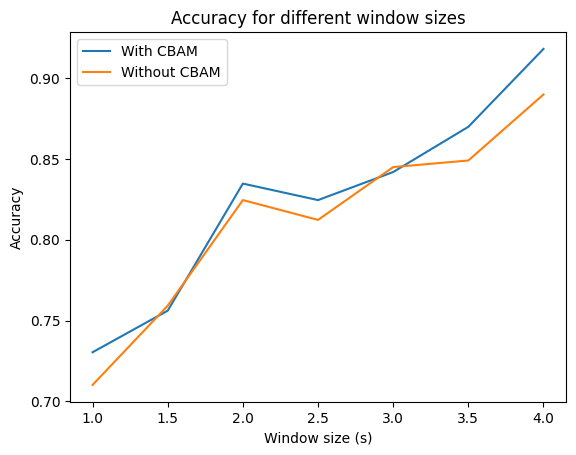

In [30]:
"""
Accuracy for window size 1: 0.7102040816326531, 0.7304081632605301 (with CBAM)
Accuracy for window size 1.5: 0.7591836734693878, 0.7561224489795918 (with CBAM)
Accuracy for window size 2: 0.8244897959183675,  0.834693877551021 (with CBAM)
Accuracy for window size 2.5: 0.8122448979591838, 0.82448979591838 (with CBAM)
Accuracy for window size 3: 0.8448979591836734, 0.8418367346938775 (with CBAM)
Accuracy for window size 3.5: 0.8489795918367347, 0.869795918367347 (with CBAM)
Accuracy for window size 4: 0.8897959183673471, 0.917959183673471 (with CBAM)
"""

# plot the results of the comment above
accs = [0.7102040816326531, 0.7591836734693878, 0.8244897959183675, 0.8122448979591838, 0.8448979591836734, 0.8489795918367347, 0.8897959183673471]
accs_cbam = [0.7304081632605301, 0.7561224489795918, 0.834693877551021, 0.82448979591838, 0.8418367346938775, 0.869795918367347, 0.917959183673471]

# use barplots
plt.plot(window_sizes, accs_cbam, label="With CBAM")
plt.plot(window_sizes, accs, label="Without CBAM")
plt.legend()
plt.xlabel("Window size (s)")
plt.ylabel("Accuracy")
plt.title("Accuracy for different window sizes")

print(f"an improvement of {np.mean(accs_cbam) - np.mean(accs)}")

(1000, 3)


(1.0, 22.0)

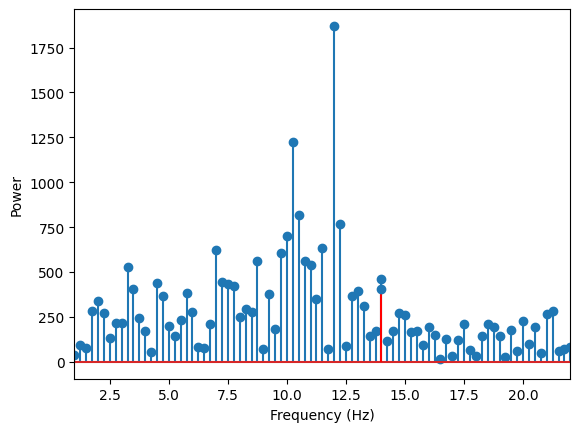

In [8]:
data = r"data\train\1\S1_0.npy"

sample = (np.load(data))
print(sample.shape)
x = sample[:, 1]
# plot the power spectrum
# transform to frequency domain, using the FFT algorithm (range of 0 - 20 Hz)
fft = np.fft.fft(x)
# calculate the frequencies
freqs = np.fft.fftfreq(len(x)) * 250
# plot the power spectrum
plt.stem(freqs, abs(fft))
# Red stem on 8hz
plt.stem(14, abs(fft)[14], 'r')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim(1, 22)

In [9]:

def get_FFT(x):
    fft = abs(np.fft.fft(x))
    # calculate the frequencies
    freqs = np.fft.fftfreq(len(x)) * 250
    return fft, freqs

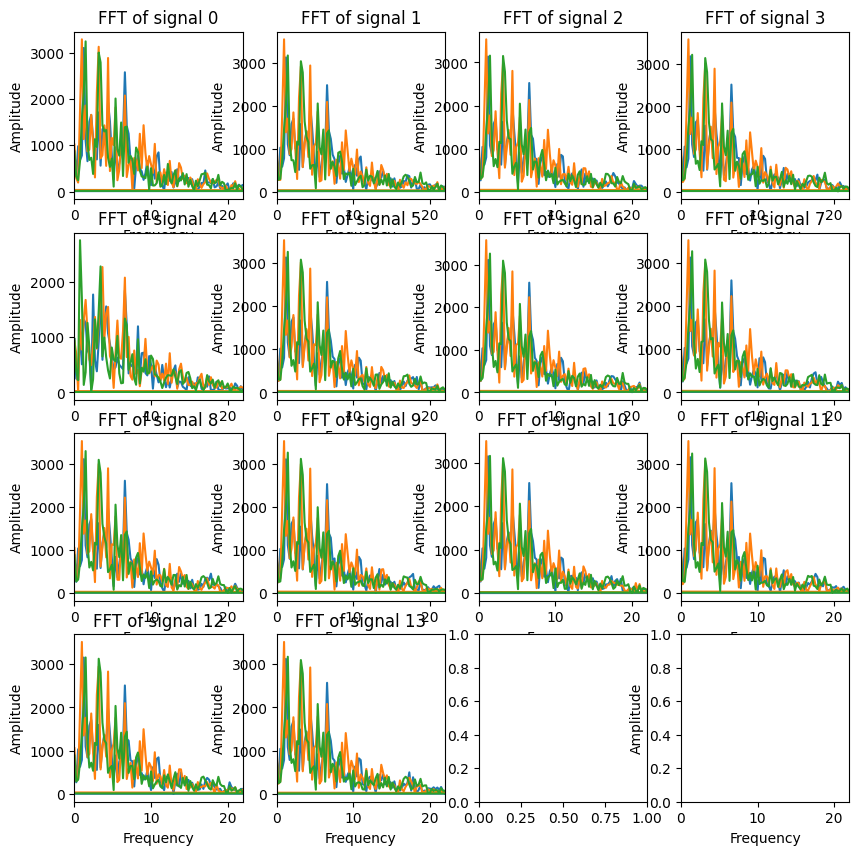

In [10]:
path = "expr/results/vanilla/ref_05_b.npy"

data = np.load(path)
# data = data[:, 1, :]

ss = int(np.ceil(np.sqrt(data.shape[0])))

fig, axs = plt.subplots(ss, ss, figsize=(10, 10))

for i in range(data.shape[0]):
    ex = (i) // ss
    ne = (i) % ss
    for j in range(data.shape[1]):
        x = data[i, j, :]
        # plot the fft  of the signal
        fft, freqs = get_FFT(x)
        axs[ex, ne].plot(freqs, fft)

    axs[ex, ne].set_title(f"FFT of signal {str(i)}")
    axs[ex, ne].set_xlabel("Frequency")
    axs[ex, ne].set_ylabel("Amplitude")
    axs[ex, ne].set_xlim(0, 22)

plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.xlim(0, 22)

plt.show()

In [11]:
path = "expr/results/vanilla/ref_00_b.npy"

data = np.load(path)
data = data[:, 1, :]


for idx in  data.shape[0]:
    x = data[i, :]
    # plot the fft  of the signal

TypeError: 'int' object is not iterable